In [1]:
%env CUDA_VISIBLE_DEVICES=-1
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
from lightning import LightningModule, Trainer
from torch.nn import functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy.stats import multivariate_normal


class PosteriorFlowDataset(Dataset):
    def __len__(self):
        return 1

    def dataloader(self, batch_size, batches=256, **kwargs):
        sampler = [batch_size] * batches
        return DataLoader(self, batch_size=None, sampler=sampler, **kwargs)

    def __getitem__(self, batch_size):
        t = np.random.rand(batch_size)
        x0 = self.sample_params(batch_size)
        x1 = self.sample_params(batch_size)
        y = self.sample_observation(x1)
        to_float = lambda x: x.astype(np.float32)
        return tuple(map(to_float, (t, x0, x1, y)))

    def log_posterior(self, params, observation):
        log_prior = self.log_prior(params)
        log_likelihood = self.log_likelihood(params, observation)
        return log_prior + log_likelihood

    def sample_params(self, batch_size):
        raise NotImplementedError

    def sample_observation(self, params):
        raise NotImplementedError

    def log_prior(self, params):
        raise NotImplementedError

    def log_likelihood(self, params, observation):
        raise NotImplementedError


class PointDataset(PosteriorFlowDataset):
    def __init__(
        self,
        prior_mean=np.zeros(3),
        prior_cov=np.eye(3),
        noise_cov=0.1 * (np.ones((3, 3)) + np.eye(3)),
    ):
        self.prior_distr = multivariate_normal(prior_mean, prior_cov)
        self.noise_distr = multivariate_normal(cov=noise_cov)

    def sample_params(self, batch_size):
        x = self.prior_distr.rvs(batch_size)
        return x

    def sample_observation(self, x):
        noise = self.noise_distr.rvs(len(x))
        return x + noise

    def log_prior(self, x):
        return self.prior_distr.logpdf(x)

    def log_likelihood(self, x, y):
        return self.noise_distr.logpdf(y - x)

In [3]:
class ConditionalFlowMatching(LightningModule):
    def __init__(self, coupling_jitter=0.0, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

    def push(self, x, y, n_steps=16, verbose=False):
        if verbose:
            print("Pushing data through flow")
        y = y.expand((x.shape[0], *y.shape))
        ts = torch.arange(0, 1, 1/n_steps).expand(x.shape[0], -1)
        for t in tqdm(ts.T, disable=not verbose):
            x = x + self(t, x, y) / n_steps
        return x

    def conditional_map(self, t, x0, x1):
        x_jitter = self.hparams["coupling_jitter"] * torch.randn_like(x0)
        while t.ndim < x0.ndim:
            t = t.unsqueeze(-1)
        xt = x0 + t * (x1 - x0) + x_jitter
        d_x = x1 - x0
        return xt, d_x

    def training_step(self, batch, batch_idx):
        t, x0, x1, y = batch
        x, d_x = self.conditional_map(t, x0, x1)
        flow = self(t, x, y)
        loss = F.mse_loss(flow, d_x)
        self.log("flow_loss", loss, prog_bar=True)
        return loss

    def __call__(self, t, x, y):
        raise NotImplementedError

In [ ]:
class MLP(nn.Sequential):
    def __init__(self, in_dim, out_dim, hidden_dim=512, depth=1, norm=True):
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.GELU())
        for _ in range(depth - 1):                
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.GELU())
            if norm:
                layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.Linear(hidden_dim, out_dim))
        super().__init__(*layers)


class ToyCNF(ConditionalFlowMatching):
    def __init__(self, dim, hidden_dim=512, depth=4, **kwargs):
        super().__init__(**kwargs)
        self.flow = MLP(
            in_dim=2 * dim + 1,
            out_dim=dim,
            hidden_dim=hidden_dim,
            depth=depth,
        )

    def __call__(self, t, x, y):
        h = torch.cat([t.unsqueeze(-1), x, y], dim=-1)
        return self.flow(h)

In [4]:
dataset = PointDataset()
model = ToyCNF(dim=3, hidden_dim=128, depth=4, lr=3e-4)
# model = torch.compile(model)

train_dataloader = dataset.dataloader(
    batch_size=1024,
    batches=256,
    num_workers=128,
    persistent_workers=True,
    pin_memory=True,
)
trainer = Trainer(max_epochs=4, callbacks=[])
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | flow | MLP  | 51.7 K
------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


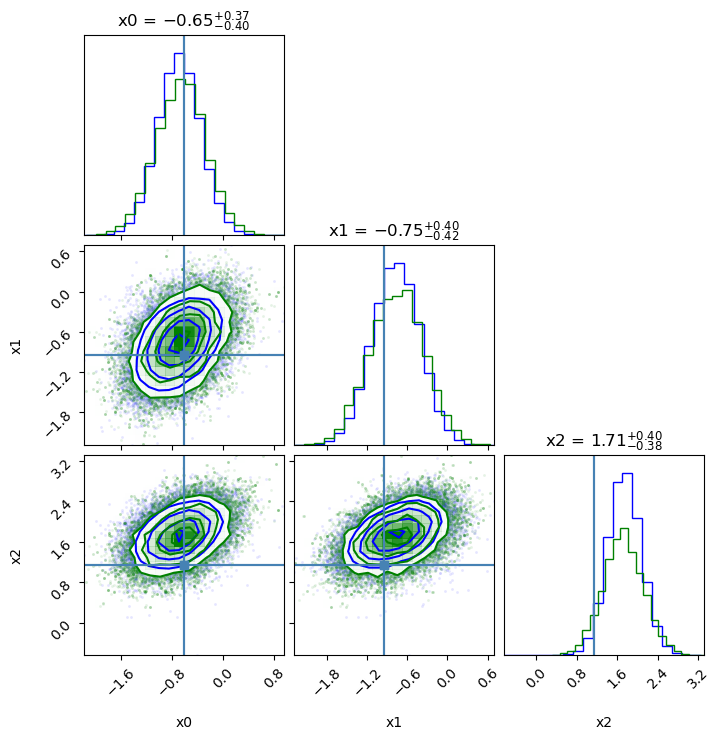

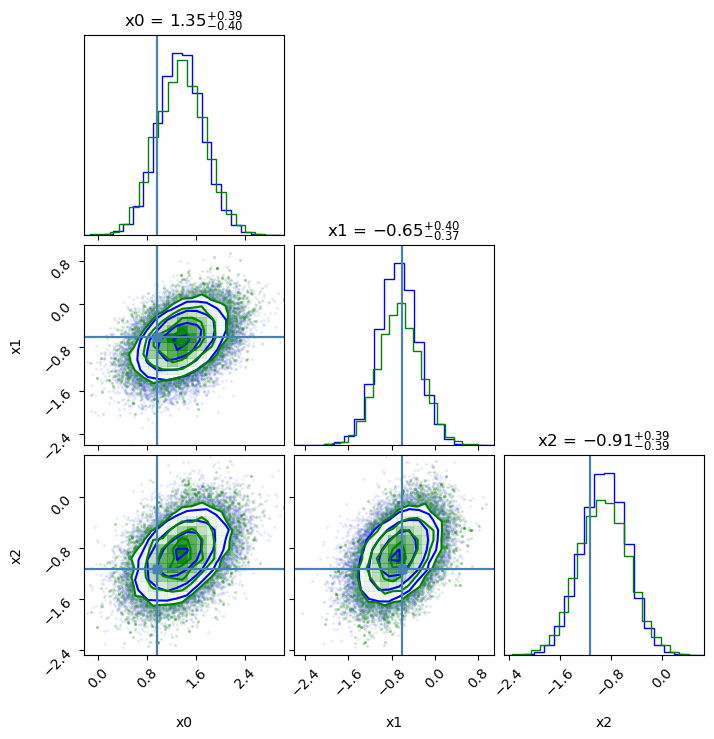

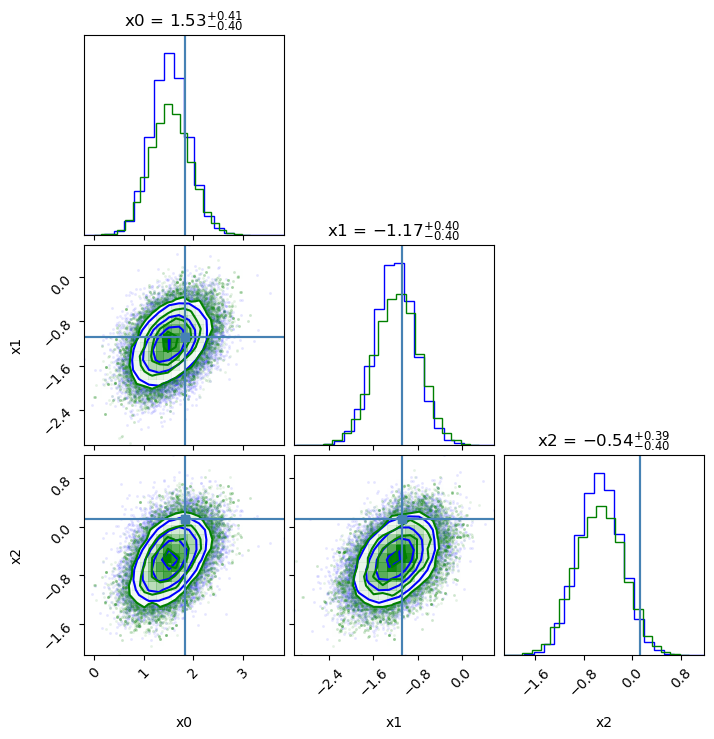

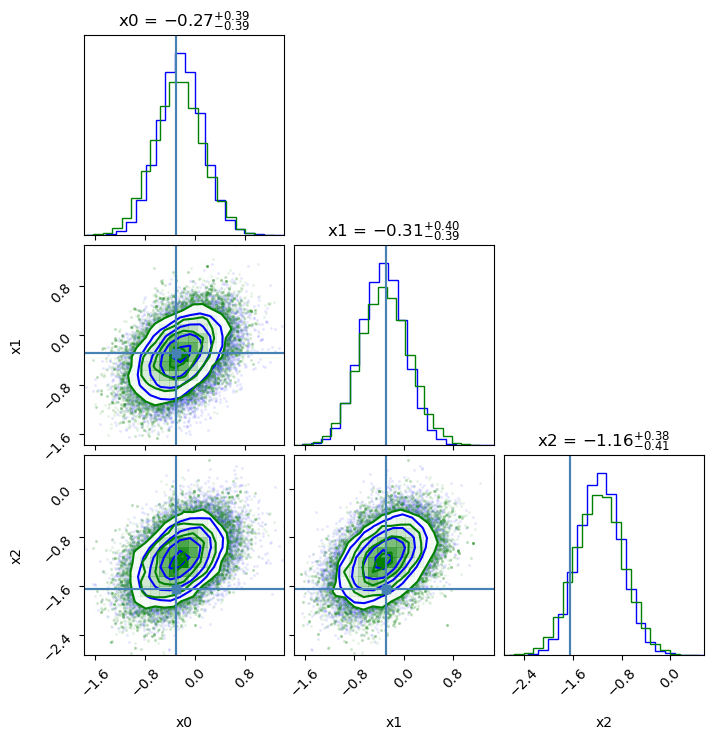

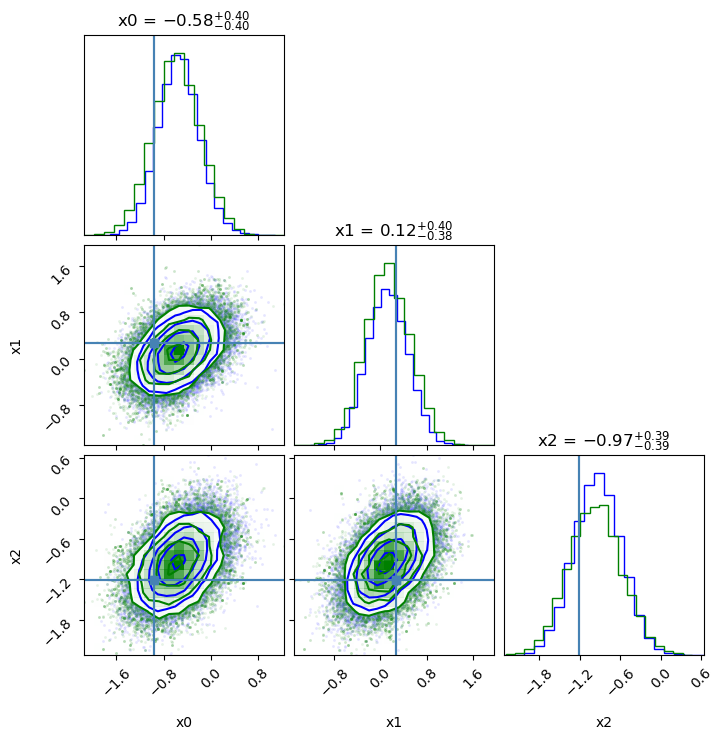

In [5]:
import corner
from mcmc import emcee_sample

verbose = False
examples = 5
samples = 32*1024
for t, x0, x1, y in tqdm(dataset.dataloader(batch_size=samples, batches=examples)):
    y, x_true = y[0], x1[0]

    # sample using CNF
    with torch.no_grad():
        x_cnf = model.push(x0, y, verbose=verbose).numpy()

    # sample using MCMC
    x_mcmc = emcee_sample(
        log_prob=lambda x: dataset.log_posterior(x, y.numpy()),
        x0=x_true.numpy(),
        walkers=64,
        steps=len(x_cnf) // 64,
        burn=300,
        verbose=verbose,
    )

    # plot corner
    corner_kwargs = dict(
        labels=[f"x{i}" for i in range(len(x_true))],
        show_titles=True,
        truths=x_true.numpy(),
    )
    fig = None
    fig = corner.corner(x_cnf, color="blue", fig=fig, **corner_kwargs)
    fig = corner.corner(x_mcmc, color="green", fig=fig, **corner_kwargs)